[![View notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/examples/PySDM_examples/Jaruga_and_Pawlowska_2018/fig_2.ipynb) 
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=lab/tree/examples/PySDM_examples/Jaruga_and_Pawlowska_2018/fig_2.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/Jaruga_and_Pawlowska/fig_2.ipynb)

#### based on Jaruga and Pawlowska (Geosci. Model Dev. 11)  "_libcloudph++ 2.0: aqueous-phase chemistry extension of the particle-based cloud microphysics scheme_"   
https://doi.org/10.5194/gmd-11-3623-2018

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

In [ ]:
from PySDM_examples.Kreidenweis_et_al_2003 import Settings, Simulation
from PySDM import products as PySDM_products
from open_atmos_jupyter_utils import show_plot
from PySDM_examples.utils.widgets import display, FloatProgress
from PySDM.physics import si
from PySDM.physics.constants import PPT, PPB
import numpy as np
import os
from matplotlib import pyplot

In [3]:
n_points = 6 if 'CI' not in os.environ else 2
nsd = np.logspace(0, n_points-1, num=n_points, base=2.0, dtype=int)

In [4]:
default_settings = Settings(1,1,1)
products = (
    PySDM_products.PeakSupersaturation(unit='%', name='S_max'),
    PySDM_products.ParticleConcentration(name='n_c_cm3', unit='cm^-3', radius_range=default_settings.cloud_radius_range),
    PySDM_products.Acidity(name='pH_conc_H_volume_weighted', radius_range=default_settings.cloud_radius_range),
    PySDM_products.AqueousMoleFraction('S_VI', name='aq_S_VI_ppb', unit='ppb')
)

In [5]:
simulations = []
progress = FloatProgress(value=0.0, min=0.0, max=1.0)
display(progress)
for it in range(n_points):
    settings = Settings(
        dt=1*si.s, 
        n_sd=nsd[it], 
        n_substep=5 if 'CI' not in os.environ else 1
    )
    settings.output_interval = 25 * si.s
    simulation = Simulation(settings, products)
    output = simulation.run()
    simulations.append({'settings': settings, 'output': output})
    progress.value += 1/n_points

FloatProgress(value=0.0, max=1.0)

In [6]:
x = np.log2(nsd)
smax = []
droplet_number = []
pH = []
sulfate_ppt = []
for simulation in simulations:
    smax.append(np.nanmax(simulation['output']["S_max"]))
    droplet_number.append(np.nanmax(simulation['output']["n_c_cm3"]))
    pH.append(simulation['output']["pH_conc_H_volume_weighted"][-1])
    S_VI = simulation['output']["aq_S_VI_ppb"]
    sulfate_ppt.append((S_VI[-1] - S_VI[0]) * PPB / PPT)

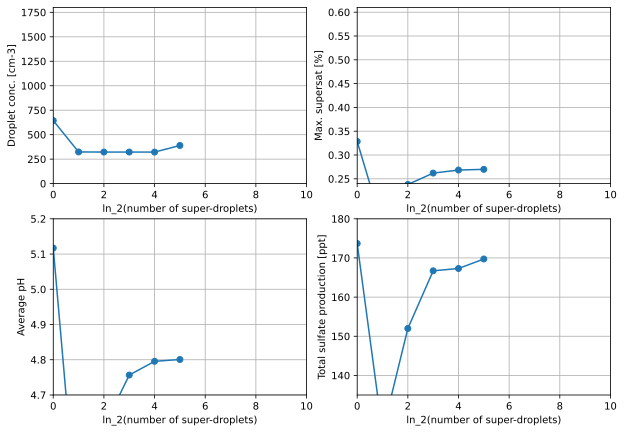

HTML(value="<a href='./fig_2' target='_blank'>./fig_2</a><br>")

In [7]:
fig, axs = pyplot.subplots(2, 2, figsize=(10,7))

axs[0][0].plot(x, droplet_number, 'o-')
axs[0][0].set_ylabel('Droplet conc. [cm-3]')
axs[0][0].set_ylim(0, 1800)

axs[0][1].plot(x, smax, 'o-')
axs[0][1].set_ylabel('Max. supersat [%]')
axs[0][1].set_ylim(0.24, 0.61)

axs[1][0].plot(x, pH, 'o-')
axs[1][0].set_ylabel('Average pH')
axs[1][0].set_ylim(4.7, 5.2)

axs[1][1].plot(x, sulfate_ppt, 'o-')
axs[1][1].set_ylabel('Total sulfate production [ppt]')
axs[1][1].set_ylim(135, 180)

for axss in axs:
    for ax in axss:
        ax.set_xlabel('ln_2(number of super-droplets)')
        ax.grid()
        ax.set_xlim(0,10)

show_plot("fig_2")